### Importing libraries

In [130]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from collections import Counter
from networkx.linalg.graphmatrix import adjacency_matrix

### Verifying raw data path
If assertion fails, download the movielens-100k ratings data from [konect](http://konect.cc/networks/movielens-100k_rating/) and put the files in data/raw.

In [131]:
raw_data_path ="data/raw/"
figure_path = "data/figures/"
bipartite_path = "data/bipartite/full_bipartite.p"

assert os.path.exists(raw_data_path)

### Create/load the bipartite network

In [132]:
if os.path.exists(bipartite_path):
    with open(bipartite_path, 'rb') as f:
        G = pickle.load(f)
    print("Graph loaded")
else:
    G = nx.Graph()
    
    with open(raw_data_path+"rel.rating.csv", 'r') as f:
        movie_ids = set()
        user_ids = set()
        edges = []
        for line in f.readlines():
            userid, movieid, rating, timestamp = tuple(map(int, line.strip().split(' ')))
            movie_ids.add(movieid)
            userid += 10000
            user_ids.add(userid)
            edges.append((userid, movieid, rating))  # Discarding the timestamp attribute of edges

    G.add_nodes_from(user_ids, bipartite=0)
    G.add_nodes_from(movie_ids, bipartite=1)
    G.add_weighted_edges_from(edges)

    with open(bipartite_path, 'wb') as f:
        pickle.dump(G, f)
    print("Graph created and saved")

Graph loaded


In [154]:
# Loading movie titles
with open(raw_data_path+"movie-titles.txt", 'r') as f:
        title_dict =  dict()
        for line in f.readlines():
            movieid, title = line.strip().split('|')[:2]
            movieid = int(movieid)
            title_dict[movieid] = title

G = nx.Graph()

# Loading edges
with open(raw_data_path+"rel.rating.csv", 'r') as f:

    for line in f.readlines():
        userid, movieid, rating, timestamp = tuple(map(int, line.strip().split(' ')))
        userid += 10000
        G.add_node(userid)
        G.add_node(movieid, title=title_dict[movieid])
        G.add_edge(userid, movieid, weight=rating)  # Discarding the timestamp attribute of edges

True

These are summary statistics of the graph from running scripts/metrics.py (removed irrellevant statistics):

#### Basic Statistics
Number of Nodes: 2625, Number of Edges: 100000, Global Density: 0.029, Global Diameter: 5 

####  Degree Statistics
Average Degree: 76.19, Five-Number-Summary Degrees: [  1.,  15.,  42., 106., 737.]

#### Connected Components Statistics
Number of CC: 1, Average CC Size: 2625.0, Average CC Density: 0.029036004645760744}, 

### Weight (Rating) Distribution

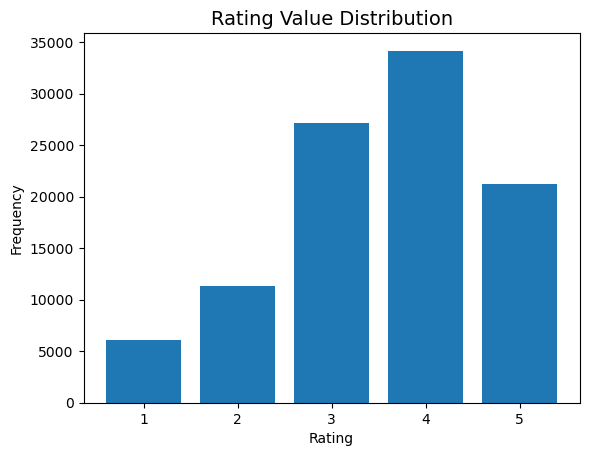

In [164]:
weights = list(edge[2]['weight'] for edge in G.edges(data=True))
unique, count = np.unique(weights, return_counts=True)
plt.bar(unique, count)
plt.title("Rating Value Distribution", size=14)
plt.xlabel("Rating")
plt.ylabel("Frequency");
np.mean(weights), np.std(weights)
plt.savefig(figure_path+"bipartite_rating_value_distribution.png")

### Visualizing Degree Distributions

In [165]:
def plot_ccdf(degree_dictionary, cumulative=True):  # takes dict(G.degree)
   dd = Counter(degree_dictionary.values())
   dd = pd.DataFrame(list(dd.items()), columns = ("degree", "count")).sort_values(by = "degree")
   ccdf = dd.sort_values(by = "degree", ascending = False)
   if cumulative:
      ccdf["cumsum"] = ccdf["count"].cumsum()
      ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
      ccdf = ccdf[["degree", "ccdf"]].sort_values(by = "degree")
   return ccdf

In [166]:
movie_degrees = {k:v for k,v in dict(G.degree()).items() if k < 10000}
user_degrees = {k:v for k,v in dict(G.degree()).items() if k >= 10000}

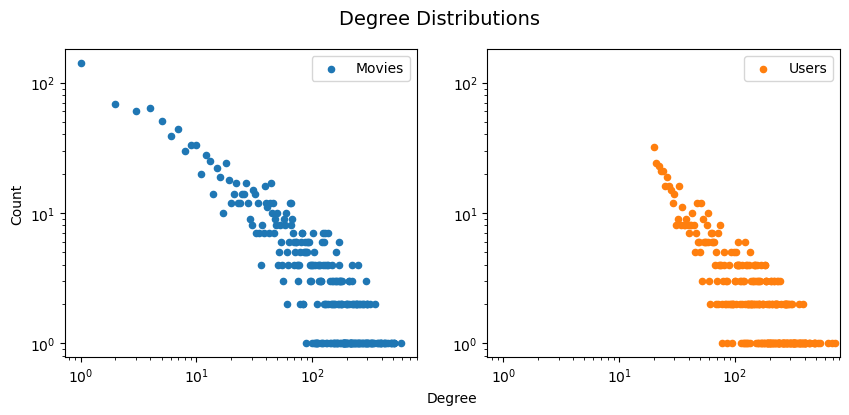

In [167]:
movie_dd = plot_ccdf(movie_degrees, cumulative=False)
user_dd = plot_ccdf(user_degrees, cumulative=False)
fig, ax = plt.subplots(1,2, figsize=(10,4))
fig.suptitle("Degree Distributions", size=14)
# plt.setp(ax, xlim=(0,1000), ylim=(0,1))
# plt.setp(ax, xlim=ax[0].get_xlim(), ylim=ax[0].get_ylim())
opacity = 1
movie_dd.plot(kind='scatter', x='degree', y='count', loglog=True, label='Movies', ax=ax[0], alpha=opacity, xlabel='Degree', ylabel='Count')
user_dd.plot(kind='scatter', x='degree', y='count', loglog=True, label='Users', ax=ax[1], alpha=opacity, color='C1', ylabel='', xlabel='')                   

# Keeping axis limits consistent and centering xlabel
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[0].xaxis.set_label_coords(1.1, -0.11)

fig.savefig(figure_path+"bipartite_dd_movies_and_users.png")

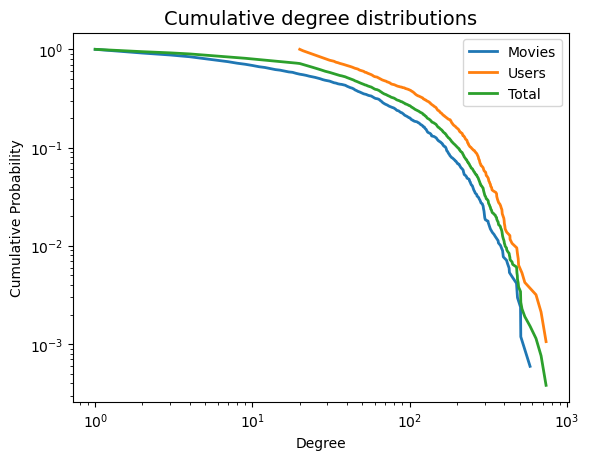

In [168]:
ax = plt.gca()

movie_ccdf = plot_ccdf(movie_degrees)
user_ccdf = plot_ccdf(user_degrees)
total_ccdf = plot_ccdf(dict(G.degree()))
            
movie_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Movies', ax=ax, linewidth=2)
user_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Users', ax=ax, linewidth=2)
total_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Total', ax=ax, linewidth=2)

ax.set_title("Cumulative degree distributions", size=14)                       
plt.ylabel("Cumulative Probability")
plt.xlabel("Degree")
                       
plt.savefig(figure_path+"bipartite_ccdf_movies_and_users.png")

In [169]:
min(user_degrees.values()), min(movie_degrees.values()), float(1-movie_ccdf[movie_ccdf['degree'] == 20]['ccdf'].iloc[0])

(20, 1, 0.4417360285374554)

The distributions are not power law; they are shifted and there is exponential cutoff. 20 is the obvious minumum of movies rated by any user, since users with fewer than 20 ratings were discarded when making the data set. Some movies on the other hand have very few ratings, the minimum being 1. 44% of movies are rated by 20 or less people.

Add for next time:
add degree distribution plots
summary statistics 
check for power low

### Generate weighted projection and get the degree centrality of both users and movies

In [146]:
# Split the graph into 2 sets: user and movie nodes
user_nodes, movie_nodes = nx.algorithms.bipartite.basic.sets(G)

# Generate the weighted projections
weighted_projection_users = bipartite.weighted_projected_graph(G, user_nodes)
weighted_projection_movie = bipartite.weighted_projected_graph(G, movie_nodes)

print(weighted_projection_users)
print(weighted_projection_movie)

Graph with 943 nodes and 429110 edges
Graph with 1682 nodes and 983206 edges


 Calculate the degree centrality of each user (why are they so high?!) (How many movies each user has rated)

In [140]:
# How many movies each user has rated
# Compute degree centrality for the users projection
users_degree_centrality = nx.degree_centrality(weighted_projection_users)

# Print the degree centrality for each node in the users projection
print("Degree centrality for users:")
for node, centrality in users_degree_centrality.items():
    print(f"Node {node}: {centrality}")


Degree centrality for users:
Node 10240: 0.9235668789808917
Node 10241: 0.9256900212314225
Node 10242: 0.9256900212314225
Node 10243: 0.9734607218683652
Node 10244: 0.9978768577494692
Node 10245: 0.935244161358811
Node 10246: 0.9851380042462845
Node 10247: 0.994692144373673
Node 10248: 0.9734607218683652
Node 10249: 0.9989384288747346
Node 10250: 1.0
Node 10251: 0.9989384288747346
Node 10252: 0.9670912951167728
Node 10253: 0.9978768577494692
Node 10254: 0.9978768577494692
Node 10255: 0.9830148619957537
Node 10256: 0.9957537154989384
Node 10257: 0.9978768577494692
Node 10258: 0.9341825902335457
Node 10259: 0.9989384288747346
Node 10260: 0.881104033970276
Node 10261: 0.9267515923566879
Node 10262: 0.9989384288747346
Node 10263: 1.0
Node 10264: 0.9968152866242038
Node 10265: 0.9872611464968153
Node 10266: 0.9554140127388535
Node 10267: 0.9564755838641189
Node 10268: 1.0
Node 10269: 0.9798301486199575
Node 10270: 1.0
Node 10271: 1.0
Node 10272: 0.9150743099787686
Node 10273: 0.846072186836

Calculate the degree centrality of each movie (why are they so high?!) (How many ratings per movie)

In [141]:
# Compute degree centrality for the movie projection
movie_degree_centrality = nx.degree_centrality(weighted_projection_movie)

# Print the degree centrality for each node in the movie projection
print("Degree centrality for movies:")
for node, centrality in movie_degree_centrality.items():
    print(f"Node {node}: {centrality}")

Degree centrality for movies:
Node 1: 0.9476502082093992
Node 2: 0.9238548483045806
Node 3: 0.8399762046400953
Node 4: 0.9440809042236764
Node 5: 0.9066032123735872
Node 6: 0.7495538370017847
Node 7: 0.943486020226056
Node 8: 0.942296252230815
Node 9: 0.9381320642474718
Node 10: 0.8661511005353957
Node 11: 0.9440809042236764
Node 12: 0.9553837001784653
Node 13: 0.925639500297442
Node 14: 0.908982748364069
Node 15: 0.9149315883402737
Node 16: 0.7870315288518739
Node 17: 0.8215348007138609
Node 18: 0.6882807852468769
Node 19: 0.7906008328375967
Node 20: 0.8483045806067817
Node 21: 0.901249256395003
Node 22: 0.952409280190363
Node 23: 0.93575252825699
Node 24: 0.9143367043426532
Node 25: 0.9339678762641286
Node 26: 0.8792385484830458
Node 27: 0.8947055324211779
Node 28: 0.9476502082093992
Node 29: 0.8798334324806664
Node 30: 0.8720999405116002
Node 31: 0.9208804283164783
Node 32: 0.9125520523497919
Node 33: 0.8726948245092208
Node 34: 0.5193337299226651
Node 35: 0.669244497323022
Node 36:

The most infuelncial user (max degree centrality), movie popularity (max degree centrality)

In [142]:
# Find the user with the highest degree centrality
most_influential_user = max(degree_centrality_users, key=degree_centrality_users.get)
centrality_value_user = degree_centrality_users[most_influential_user]

# Add the 1000 to user ID
most_influential_user += 10240

print(f"The most influential user is {most_influential_user} with degree centrality {centrality_value_user}")


# Find the movie with the highest degree centrality
most_rated_movie = max(degree_centrality_movies, key=degree_centrality_movies.get)
centrality_value_movie = degree_centrality_movies[most_rated_movie]

print(f"The most rated movie is {most_rated_movie} with degree centrality {centrality_value_movie}")



NameError: name 'degree_centrality_users' is not defined

Followed Marie's way of getting the projection and it gets the same results, since the reuslts up there were suspicious 

In [ ]:
# Followed Marie's nodes from the exercises to get the degree centrality,since the achieved results looked suspicious.
# Split the graph into 2 sets: user and movie nodes
#user_nodes, movie_nodes = nx.algorithms.bipartite.basic.sets(G)
nodes = nx.algorithms.bipartite.basic.sets(G)

# turn the bipartite network into an adjacency matrix
adjmat_user = nx.algorithms.bipartite.matrix.biadjacency_matrix(G, nodes[1])
adjmat_movie = nx.algorithms.bipartite.matrix.biadjacency_matrix(G, nodes[0])

# we then use the simple weighting method to get the weighted projection 
#projected_users = adjmat_users.dot(adjmat_user.T)
#print(projected_users)
#In your example, the entry (0, 486) 10 
# indicates that user 0 is connected to user 486 with a strength of 10.


projected_movies = adjmat_movies.dot(adjmat_movies.T) 

#Create weighted graphs from the weighted adjacency matrices
#G_users = nx.Graph(projected_users)
G_movies = nx.Graph(projected_movies)

# Step 2: Calculate degree centrality for users and movies
#degree_centrality_users = nx.degree_centrality(G_users)
degree_centrality_movies = nx.degree_centrality(G_movies)

# Print the degree centrality for users
#for user, centrality in degree_centrality_users.items():
    #print(f"User {user} has degree centrality: {centrality}")

# Print the degree centrality for movies
for movie, centrality in degree_centrality_movies.items():
    print(f"Movie {movie} has degree centrality: {centrality}")


Movie 0 has degree centrality: 0.9488399762046401
Movie 1 has degree centrality: 0.9250446162998216
Movie 2 has degree centrality: 0.8411659726353361
Movie 3 has degree centrality: 0.9452706722189174
Movie 4 has degree centrality: 0.9077929803688282
Movie 5 has degree centrality: 0.7507436049970256
Movie 6 has degree centrality: 0.9446757882212969
Movie 7 has degree centrality: 0.943486020226056
Movie 8 has degree centrality: 0.9393218322427127
Movie 9 has degree centrality: 0.8673408685306365
Movie 10 has degree centrality: 0.9452706722189174
Movie 11 has degree centrality: 0.9565734681737061
Movie 12 has degree centrality: 0.926829268292683
Movie 13 has degree centrality: 0.91017251635931
Movie 14 has degree centrality: 0.9161213563355146
Movie 15 has degree centrality: 0.7882212968471148
Movie 16 has degree centrality: 0.8227245687091017
Movie 17 has degree centrality: 0.6894705532421178
Movie 18 has degree centrality: 0.7917906008328376
Movie 19 has degree centrality: 0.84949434860

### Research Question
#### How to recommend movies based on user ratings, given a list of liked movies?
* Potential problem: if our sample of users is too large, we are likely to just recommend the most rated movies, not specific movies you would like. To test this, we could plot correlation between movie degree and likelihood to recommend.

* Sample users who liked the movie(s), project onto their rated movies, recommend highest weight neighbor of liked movies.

* Construct similar movies to the ones you like, use this to find users like you, and iterate to converge on movies you will like.

* Evaluation metric: For a sample of users, sampling their liked movies, how likely are we to recommend another movie that they like (reviewed highly)?
